**Behavior and Imaging Correlation** 

This notebook provides tools for correlation between the normalized movement of experimental mice and the dF/F calcium two-photon imaging data to investigate possible involvement of recorded neurons in the motor activity from the corresponding video trials.

In [1]:
import os
from glob import glob
import json
import scipy
import math
from scipy import ndimage
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import genfromtxt
from scipy.stats import pearsonr
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
from io_utils import find_trials, session_time, read_trial_coordinates, read_speed_coordinates
from body_part_calc import rename_columns, add_speed_columns

raw_data = scipy.io.loadmat('/root/capsule/data/Jan18/bci_session_data/sorted_data/data_behav_BCI29_042222.mat')

In the following cell, **"video_dir"** and **"csv_dir"** might have the same pathway for DeepLabCut-generated files or contain two different pathways for Lightning Pose CSVs.
1. "project_name" is the name of the data asset in the "data" folder.
2. "video_dir" is the directory that contains experimental video files.
3. "data_dir" corresponds to the data asset folder.
4. "csv_dir" is the pathway to the folder with the CSV files containing predictions.
5. "json_dir" is the pathway to the experimental JSON files for every trial video.
6. "output_dir" is generated automatically and will save all outputs.

In [2]:
# Identifying directories with relevant data and information
project_name = 'pred_ophys_whiskers-Alena-2024-07-19'
video_dir = os.path.join('/root/capsule/data/pred_ophys_whiskers-Alena-2024-07-19/videos')
data_dir = os.path.join('/root/capsule/data/pred_ophys_whiskers-Alena-2024-07-19')
csv_dir = os.path.join('/root/capsule/data/pred_ophys_whiskers-Alena-2024-07-19/videos/')
json_dir = os.path.join('/root/capsule/data/single-plane-ophys_608551_2022-04-22_12-39-41/behavior-videos/side/2022-04-22_12-08-56')

# Creating an output directory in scratch
output_dir = os.path.join(f"/root/capsule/scratch",
                            project_name)
Path(output_dir).mkdir(parents=True, exist_ok=True)

The **"find_trials"** function goes through the trial video names and trims the extension to obtain the full list of the session's contents. The current method in io_utils.py is set up for DeepLabCut, need to change one line in the code if using Lightning Pose data (see instructions in the module).

**"session_time"** loops through the trial JSON files and calculates the overall session length. Additionally, the code below identifies the frames within the imaging dataset that correspond to specific trials.

In [3]:
trial_start = raw_data['trial_start'].squeeze()
trial_indices = np.where(trial_start==1)[0]

# Finding the trials from the data folder
dfs_df = find_trials(video_dir, csv_dir, trial_indices)
print(dfs_df.dtypes)
dfs_df.to_csv(f'/root/capsule/scratch/{project_name}/session_data.csv', index=None)

# Finding out the length of the session
session_length = session_time(json_dir)
print(session_length)

trial_00000__2022-04-22_12-08-56DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (0, 248)
trial_00001__2022-04-22_12-09-19DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (248, 729)
trial_00002__2022-04-22_12-09-44DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (729, 868)
trial_00003__2022-04-22_12-09-51DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (868, 1249)
trial_00004__2022-04-22_12-10-11DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (1249, 1453)
trial_00005__2022-04-22_12-10-21DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (1453, 1607)
trial_00006__2022-04-22_12-10-29DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (1607, 1794)
trial_00007__2022-04-22_12-10-39DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (1794, 1950)
trial_00008__2022-04-22_12-10-47DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (1950, 2184)
trial_00009__2022-04-22_12-10-59DLC_resnet50_ophys_whiskersJul19shuffle1_100000: (2184, 2879)
trial_00010__2022-04-22_12-11-35DLC_resnet50_ophys_whiskersJul19shuff

In [4]:
# Pull the dF/F values into a variable.
dFF = raw_data['df_closedLoop'] # frames X neurons
print(len(dFF))
# Print out the frame start and end times that correspond to the trials.
trial_start = raw_data['trial_start'].squeeze() # frames
rewards = raw_data['rew'].squeeze()

# Two-photon microscope sampling rate.
sampling_rate = 1/raw_data['dt_si'][0][0]
sampling_rate 

32391


19.4141

Below is the visualization of recordings for one neuron throughout the whole session.

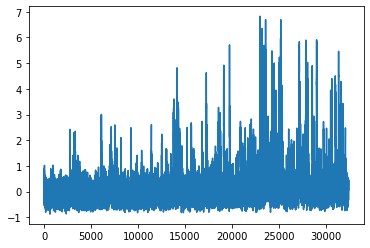

In [5]:
# Graph of dF/F that demonstrates the trials and introduction of rewards.
# Can use indexing to visualize relevant parts of the session.
%matplotlib inline
plt.plot(dFF[:32391, 1])
# plt.plot(trial_start[:250]) 
# plt.plot(rewards[:250])
#plt.axis(ymin = 0)

In [6]:
df = pd.read_csv(f'/{output_dir}/session_data.csv')

# Extracting the number of frames minus the header.
frames = len(df) - 1
print(f'Number of frames within the behavior data CSV file: {frames}.')

frame_rate = frames / session_length
print(f'Average camera frame rate for the session: {frame_rate}.')
      
timing = 1 / frame_rate
print(f'Average time in seconds per frame: {timing}.')

<ipython-input-6-fad58ee8e55a>:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'/{output_dir}/session_data.csv')


Number of frames within the behavior data CSV file: 631666.
Average camera frame rate for the session: 416.8245358554325.
Average time in seconds per frame: 0.002399091017873359.


Code below adjusts the data frame format from that of DLC/LP to the capsule's required format. Depending on the number of underscores in the keypoint names, need to change one line in "body_part_calc.py" module (see instructions inside the method).

In [7]:
# Adjust_coordinates method assumes DLC and LP-generated CSV file format.
# It removes the header and merges two following rows together with an underscore in between.
adjusted_coords_df = read_trial_coordinates(f'/{output_dir}/session_data.csv')
rename_columns(adjusted_coords_df)
adjusted_coords_df.astype('float').dtypes
adjusted_coords_df.to_csv(f'/{output_dir}/adjusted_coords.csv', index = False)
print(adjusted_coords_df)

                  tongue_tip_x  tongue_tip_y  tongue_tip_likelihood  \
bodyparts_coords                                                      
0                   310.306549    176.380173               0.009805   
1                   424.576111    185.622513               0.011460   
2                   310.851746    177.666382               0.005762   
3                   424.831909    185.287048               0.008424   
4                   424.502899    185.629105               0.007261   
...                        ...           ...                    ...   
2620                362.382599    161.367249               0.017073   
2621                361.884155    161.137589               0.013969   
2622                362.547363    160.976685               0.020324   
2623                362.060211    161.136810               0.015872   
2624                362.055023    160.993210               0.014933   

                  tongue_mid_x  tongue_mid_y  tongue_mid_likelihood  \
bodyp

After the normalized speed is calculated for multiple whisker labels, they need to be averaged to find the speed of the body part as a whole.

{'whiskert', 'whiskerm', 'whiskerr'}
        tongue_tip_x  tongue_tip_y  tongue_tip_likelihood  tongue_mid_x  \
0         310.306549    176.380173               0.009805    319.843994   
1         424.576111    185.622513               0.011460    319.420929   
2         310.851746    177.666382               0.005762    319.345306   
3         424.831909    185.287048               0.008424    318.806976   
4         424.502899    185.629105               0.007261    318.782257   
...              ...           ...                    ...           ...   
631660    362.382599    161.367249               0.017073    360.769989   
631661    361.884155    161.137589               0.013969    360.176422   
631662    362.547363    160.976685               0.020324    372.539398   
631663    362.060211    161.136810               0.015872    372.721436   
631664    362.055023    160.993210               0.014933    360.041382   

        tongue_mid_y  tongue_mid_likelihood  whiskert_root_x  

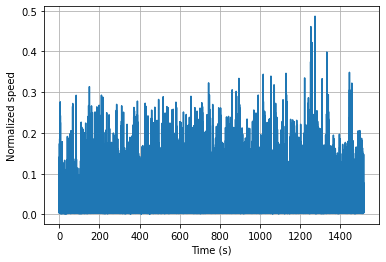

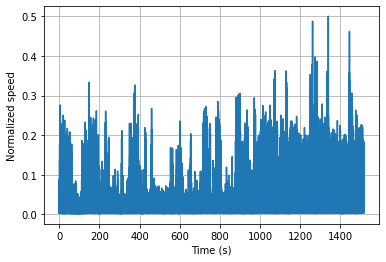

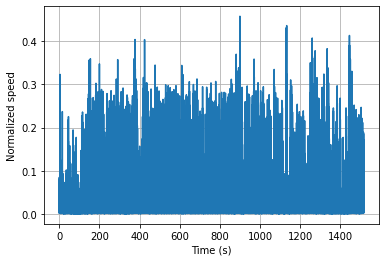

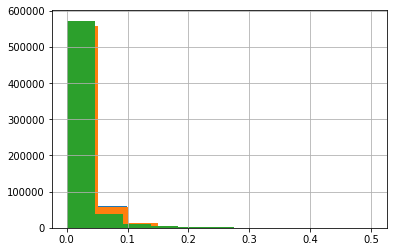

In [8]:
# Calculating speed for the body parts in question. Go to the "body_part_calc.py" module to adjust calculation to needed bodyparts.
speed_df = read_speed_coordinates(f'/{output_dir}/adjusted_coords.csv')
add_speed_columns(speed_df, frame_rate)

whisker_locs = set([col.split('_')[0] for col in speed_df.columns[7:79] if '_' in col])
print(whisker_locs)

for whisker_loc in whisker_locs:
    root = f'{whisker_loc}_root_norm_speed'
    mid1 = f'{whisker_loc}_mid1_norm_speed'
    mid2 = f'{whisker_loc}_mid2_norm_speed'
    top = f'{whisker_loc}_top_norm_speed'

    if root in speed_df.columns and mid1 in speed_df.columns and mid2 in speed_df.columns and top in speed_df.columns:
        speed_df[f'{whisker_loc}_norm_speed'] = (speed_df[root] + speed_df[mid1] + speed_df[mid2] + speed_df[top]) / 4

speed_df.to_csv(f'{output_dir}/speed.csv', index = False)

print(speed_df)

# Change the column names based on the bodypart in question.
for column in speed_df[['whiskert_norm_speed', 'whiskerm_norm_speed', 'whiskerr_norm_speed']]:
    plt.figure()
    plt.plot(speed_df['time (seconds)'], speed_df[column])
    plt.ylabel('Normalized speed')
    plt.xlabel('Time (s)')
    plt.grid(True)
    plt.show()
        
for column in speed_df[['whiskert_norm_speed', 'whiskerm_norm_speed', 'whiskerr_norm_speed']]:
    hist = speed_df[column].hist()
    
csv_file = f'{output_dir}speed.csv'

In [9]:
downsamp = genfromtxt(f'{output_dir}/speed.csv', delimiter=',')
print(downsamp[:,-3])
filtered = scipy.ndimage.median_filter(downsamp[:,[-3,-2,-1]], size=20)
filtered_df = pd.DataFrame(filtered)
print(filtered_df)

filtered_df.columns = speed_df.columns[-3:]
print(filtered_df)
filtered_df.to_csv(f'{output_dir}/filtered.csv')

# Downsampling the speed dataframe to the same amount of rows as in calcium imaging data.
# Example: there are 21 frames of behavior per 1 frame of calcium imaging for trial_00000.

downsamp_rate = frame_rate / sampling_rate
print(downsamp_rate)

sequence_interval = 1
step_size = np.round(downsamp_rate / sequence_interval).astype("int")

downsampled = pd.read_csv(f'{output_dir}/filtered.csv')

downsampled_df = downsampled.iloc[::step_size, :]
downsampled_df.to_csv(f'{output_dir}/downsamp.csv')

[       nan        nan 0.0246927  ... 0.03952571 0.03619639 0.02650965]
               0         1         2
0       0.012428  0.012428  0.013706
1       0.011299  0.012141  0.013706
2       0.009164  0.009265  0.021457
3       0.023954  0.028029  0.009908
4       0.030961  0.030961  0.035537
...          ...       ...       ...
631661  0.026510  0.026510  0.026510
631662  0.023188  0.023188  0.025068
631663  0.023188  0.023188  0.025068
631664  0.023188  0.025068  0.026510
631665  0.023188  0.023188  0.025068

[631666 rows x 3 columns]
        whiskert_norm_speed  whiskerm_norm_speed  whiskerr_norm_speed
0                  0.012428             0.012428             0.013706
1                  0.011299             0.012141             0.013706
2                  0.009164             0.009265             0.021457
3                  0.023954             0.028029             0.009908
4                  0.030961             0.030961             0.035537
...                     ...          

Computing Pearson's correlation coefficient for all the neurons in the imaging dataset and body parts in question. Might have to adjust indices if the number of missing values is significant.

In [24]:
from scipy.signal import oaconvolve

conv_values = []
top_whisker = filtered[:631665, -3]  
t = np.array(speed_df['time (seconds)'])  

# Define the exponential decay function
exp_decay = np.exp(-t)

# Perform the convolution
V1 = oaconvolve(top_whisker, exp_decay, mode='same')
conv_values.append(V1)

middle_whisker = filtered[:631665, -2]   
V2 = oaconvolve(middle_whisker, exp_decay, mode='same')
conv_values.append(V2)

root_whisker = filtered[:631665, -1]   
V3 = oaconvolve(root_whisker, exp_decay, mode='same')
conv_values.append(V3)

print(conv_values)

[array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([5.75228769e+00, 5.75103710e+00, 5.75220898e+00, ...,
       3.17339544e-15, 4.02423335e-16, 1.78216048e-15])]


        whiskert_norm_speed  whiskerm_norm_speed  whiskerr_norm_speed
0                       NaN                  NaN         5.752288e+00
1                       NaN                  NaN         5.751037e+00
2                       NaN                  NaN         5.752209e+00
3                       NaN                  NaN         5.756548e+00
4                       NaN                  NaN         5.762076e+00
...                     ...                  ...                  ...
631660                  NaN                  NaN        -3.046920e-15
631661                  NaN                  NaN         7.128642e-16
631662                  NaN                  NaN         3.173395e-15
631663                  NaN                  NaN         4.024233e-16
631664                  NaN                  NaN         1.782160e-15

[631665 rows x 3 columns]


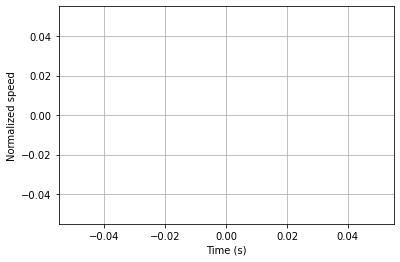

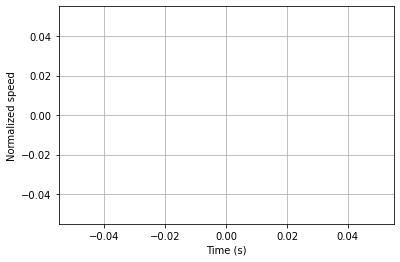

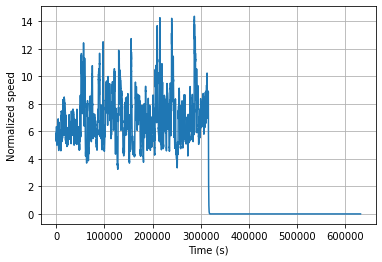

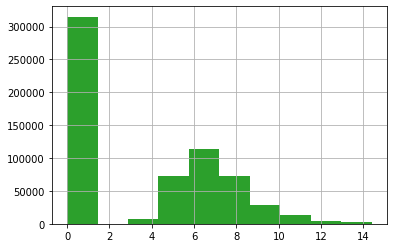

In [29]:
conv_df = pd.DataFrame(conv_values)
conv_df_transposed = conv_df.T
conv_df_transposed = conv_df_transposed.loc[~(conv_df_transposed==0).all(axis=1)]
conv_df_transposed.columns = speed_df.columns[-3:]
print(conv_df_transposed)

for column in conv_df_transposed[['whiskert_norm_speed', 'whiskerm_norm_speed', 'whiskerr_norm_speed']]:
    plt.figure()
    plt.plot(conv_df_transposed.index, conv_df_transposed[column])
    plt.ylabel('Normalized speed')
    plt.xlabel('Time (s)')
    plt.grid(True)
    plt.show()
        
for column in conv_df_transposed[['whiskert_norm_speed', 'whiskerm_norm_speed', 'whiskerr_norm_speed']]:
    hist = conv_df_transposed[column].hist()

In [40]:
# Creating a calcium imaging dataframe to do further analysis and plot the dF/F/t graph.
print(dFF.shape)
corr_coeff_whiskert = []
corr_coeff_whiskerm = []
corr_coeff_whiskerr = []

for n in range(dFF.shape[1]):
    dFFt = pd.DataFrame(dFF[:30079, n])
    dFFt = dFFt.dropna()
        
    behav = pd.read_csv(f'/{output_dir}/downsamp.csv')
    behav = behav.dropna()
    
    if len(dFFt) != len(behav):
        continue

    whiskert_cal_beh = pearsonr(dFFt[0], behav['whiskert_norm_speed'])
    corr_coeff_whiskert.append(whiskert_cal_beh)
    coeff_whiskert_df = pd.DataFrame(corr_coeff_whiskert)
    coeff_whiskert_df.to_csv(f'{output_dir}/whiskert_corr_coefficients.csv', index=None)

    whiskerm_cal_beh = pearsonr(dFFt[0], behav['whiskerm_norm_speed'])
    corr_coeff_whiskerm.append(whiskerm_cal_beh)
    coeff_whiskerm_df = pd.DataFrame(corr_coeff_whiskerm)
    coeff_whiskerm_df.to_csv(f'{output_dir}/whiskerm_corr_coefficients.csv', index=None)

    whiskerr_cal_beh = pearsonr(dFFt[0], behav['whiskerr_norm_speed'])
    corr_coeff_whiskerr.append(whiskerr_cal_beh)
    coeff_whiskerr_df = pd.DataFrame(corr_coeff_whiskerr)
    coeff_whiskerr_df.to_csv(f'{output_dir}/whiskerr_corr_coefficients.csv', index=None)

(32391, 544)


The graphs below are generated only for one neuron at a time as examples. 

In [ ]:
#Creating graphs that demonstrate the concatenation of two normalized graphs.

dFFt = pd.DataFrame(dFF[:30080, 1])
dFFt.index = dFFt.index / sampling_rate

dFFt['rescaled'] = dFFt.index

ax = dFFt.plot(x='rescaled')
behav.plot(x='time (seconds)', y='whiskert_norm_speed', ax=ax)
plt.axis(ymin = 0)
plt.legend(('dF/F', 'Top Whisker Speed (Normalized)'), loc='upper right')
plt.xlabel("Time (s)")
plt.savefig(f'/{output_dir}/corr_graph_top.png')

ax = dFFt.plot(x='rescaled')
behav.plot(x='time (seconds)', y='whiskerm_norm_speed', ax=ax)
plt.axis(ymin = 0)
plt.legend(('dF/F', 'Middle Whisker Speed (Normalized)'), loc='upper right')
plt.xlabel("Time (s)")
plt.savefig(f'/{output_dir}/corr_graph_mid.png')

ax = dFFt.plot(x='rescaled')
behav.plot(x='time (seconds)', y='whiskerr_norm_speed', ax=ax)
plt.axis(ymin = 0)
plt.legend(('dF/F', 'Root Whisker Speed (Normalized)'), loc='upper right')
plt.xlabel("Time (s)")
plt.savefig(f'/{output_dir}/corr_graph_root.png')